In [1]:
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *
data_dict = load_data(verbose=True)

CONTENTS OF HDF5 FILE:
pose
	 ekf_ori, tango_ori, tango_pos
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce, game_rv, grav, gyro, gyro_uncalib, linacce, magnet, rv, time


In [99]:
w = data['synced/gyro']
a = data['synced/acce']
m = data['synced/magnet']
q_tango = data['pose/tango_ori']
p_tango = data['pose/tango_pos']
dt = data['synced/time'][1] - data['synced/time'][0]

In [100]:
R = get_body2world_rot(m[0], a[0])
q0 = quat_initial = rotation_matrix_2_quaternion(np.linalg.inv(R))

'est',q0, 'true',q_tango[:1].reshape(-1,1)

('est',
 array([[ 0.37578564],
        [ 0.62505364],
        [ 0.36336434],
        [-0.57970635]]),
 'true',
 array([[ 0.34436653],
        [ 0.59040797],
        [ 0.35096438],
        [-0.64004271]]))

# Simple integration over time

In [101]:
# 100 time steps
N = 100
p_pred, q_pred, v_pred = np.zeros((N,3)), np.zeros((N,4)), np.zeros((N,3))

q_pred[0] = q_tango[0]#q0.flatten()
p_pred[0] = p_tango[0]

factor= .002                                # has been set arbitrarily
for i in range(1,N):
    q_pred[i] = Theta(w[i]*factor, dt=dt)@q_pred[i-1]
    a_directed = quat_2_rotation_matrix(q_pred[i])@a[i]
    v_pred[i] = v_pred[i-1] + a_directed * dt
    p_pred[i] = p_pred[i-1] + v_pred[i] * dt + .5 * a_directed * dt**2
    

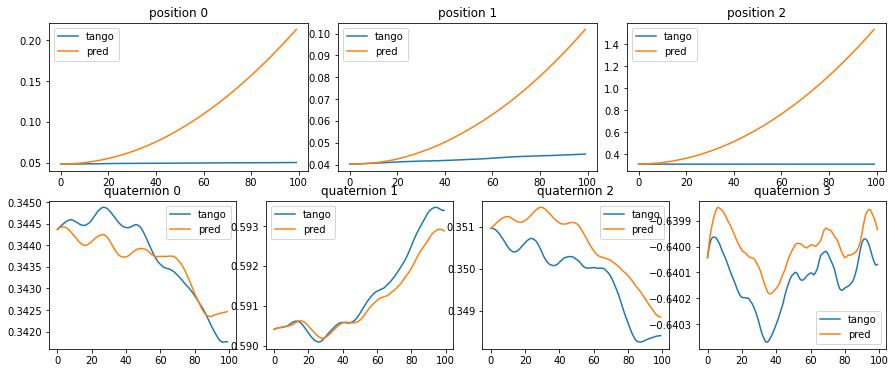

In [102]:
def plot_trajectory(p_tango, p_pred, q_tango, q_pred):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 12, wspace=0.7, hspace=0.2)
    ax_p = [fig.add_subplot(gs[0, :4]), fig.add_subplot(gs[0, 4:8]), fig.add_subplot(gs[0, 8:])]
    ax_q = [fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[1, 3:6]), fig.add_subplot(gs[1, 6:9]), fig.add_subplot(gs[1, 9:])]

    # plot positions
    for i in range(3):
        ax_p[i].plot(p_tango[:,i], label='tango')
        ax_p[i].plot(p_pred[:,i], label='pred')
        ax_p[i].set_title('position {}'.format(i))
        ax_p[i].legend()

    # plot quaternions
    for i in range(4):
        ax_q[i].plot(q_tango[:,i], label='tango')
        ax_q[i].plot(q_pred[:,i], label='pred')
        ax_q[i].set_title('quaternion {}'.format(i))
        ax_q[i].legend()

    return fig

plot_trajectory(p_tango[:N], p_pred[:N], q_tango[:N], q_pred[:N]);

# Employing convariance matrix

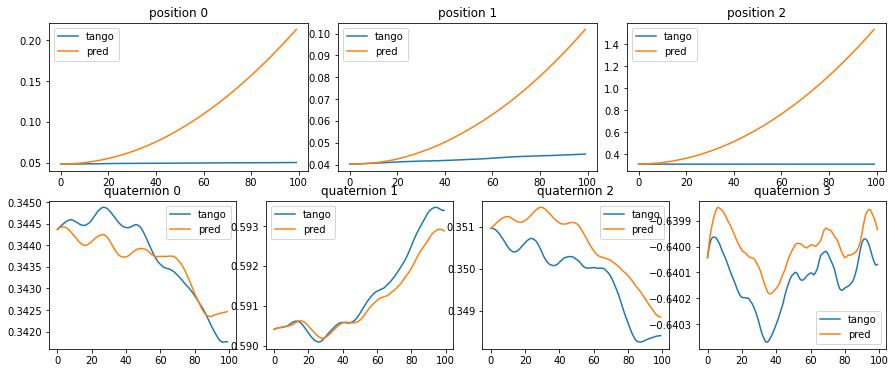

In [103]:
plot_trajectory(p_tango[:N], p_pred[:N], q_tango[:N], q_pred[:N]);

In [104]:
from scipy.spatial.transform import Rotation

# State vector: [position, velocity, quaternion] (10 elements)
x = np.zeros(10)
x[-4:] = q_tango[0]
x[:3] = p_tango[0]

# Initial state covariance
P = np.eye(10) * 0
# make it block diagonal
P[:3,:3] += 0.1
P[3:6,3:6] += 0.1
P[6:,6:] += 0.1

# Process noise covariance matrix
Q = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# Measurement noise covariance matrix
R = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# Generate synthetic IMU measurements (replace with real data)
accel_measurements = a[:N]/100#np.random.normal(0, np.sqrt(R[0][0]), (100, 3))
gyro_measurements = w[:N]#np.random.normal(0, np.sqrt(R[3][3]), (100, 3))

# Time step (delta t)
#dt = 0.1#

def state_transition(x, accel, gyro, dt):
    # Extract position, velocity, and quaternion from the state
    pos = x[:3]
    vel = x[3:6]
    quat = x[6:]

    # Update position and velocity using acceleration measurements
    pos_new = pos + vel * dt + 0.5 * accel * dt**2
    vel_new = vel + accel * dt

    # Update quaternion using gyroscope measurements
    rotation = Rotation.from_quat(quat)
    rotation_new = rotation * Rotation.from_rotvec(gyro * dt)
    quat_new = rotation_new.as_quat()

    # Construct the new state vector
    x_new = np.hstack((pos_new, vel_new, quat_new))

    return x_new

def observation_model(x):
    return x  # The observation model is the identity function in this example

def ekf(x, P, accel, gyro, dt):
    # Prediction step
    x_pred = state_transition(x, accel, gyro, dt)

    # Linearize the state transition function using the Jacobian
    F = np.eye(10)
    F[:3, 3:6] = dt * np.eye(3)

    P_pred = F @ P @ F.T + Q

    # Update step
    z = x_pred  # Assume the measurements are equal to the predicted state
    y = z - observation_model(x_pred)
    H = np.eye(10)  # Linearized observation model

    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_update = x_pred + K @ y

    # P_update = (np.eye(10) - K @ H) @ P_pred
    # replaced with: https://sites.utexas.edu/renato/files/2017/04/CUKF_ver06.pdf
    P_update = (np.eye(10) - K @ H) @ P_pred @ (np.eye(10) - K @ H).T + K @ R @ K.T 

    return x_update, P_update

# Run the EKF and store the position, velocity, and quaternion estimates
position_estimates = []
velocity_estimates = []
quaternion_estimates = []

for accel, gyro in zip(accel_measurements, gyro_measurements):
    x, P = ekf(x, P, accel, gyro, dt)
    position_estimates.append(x[:3])
    velocity_estimates.append(x[3:6])
    quaternion_estimates.append(x[6:])

#Convert results to numpy arrays
position_estimates = np.array(position_estimates)
velocity_estimates = np.array(velocity_estimates)
quaternion_estimates = np.array(quaternion_estimates)


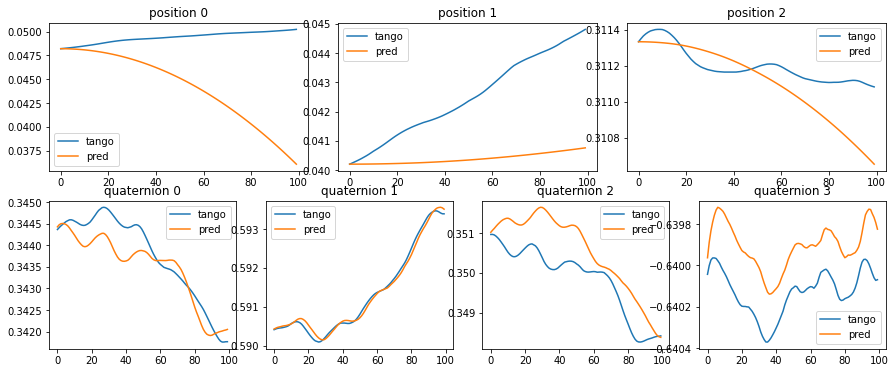

In [105]:
plot_trajectory(p_tango[:N], position_estimates[:N], q_tango[:N], quaternion_estimates[:N]);